In [1]:
# for data handling and similar task
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# for deep learning models
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
# !pip install livelossplot
from livelossplot import PlotLossesKeras
from keras.callbacks import ModelCheckpoint, EarlyStopping

# other
import warnings; warnings.filterwarnings('ignore')

In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/Crypto closing price/'

/content/drive/MyDrive/Colab Notebooks/Crypto closing price


In [3]:
df_train = pd.read_csv('Data/Train.csv')
df_test = pd.read_csv('Data/Test.csv')

In [4]:
df_train.head()

,id,asset_id,open,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_volume,percent_change_24h,market_cap_global,close
0,ID_322qz6,1,9422.849081,9428.490628,9422.849081,7.131986e+08,1.737635e+11,1689.0,817.0,55.0,105.0,61.0,271.0,3420.0,1671.0,11675867.0,39.0,1343.0,448.0,2237.0,124.0,330.0,331.0,2515.0,120.0,506133.0,1326610.0,1159677.0,8406185.0,281329.0,11681999.0,3.6,69.0,2.7,3.6,3.3,66.0,0.007118,1.0,606.0,2.0,1.0,1.0,2.0,5.0,4422,1.434516,2.818066e+11,9428.279323
1,ID_3239o9,1,7985.359278,7992.059917,7967.567267,4.004755e+08,1.426942e+11,920.0,544.0,20.0,531.0,103.0,533.0,1491.0,242.0,5917814.0,195.0,1070.0,671.0,3888.0,1.0,52.0,315.0,1100.0,23.0,1320.0,381117.0,1706376.0,3754815.0,80010.0,5924770.0,3.7,1.0,2.0,2.0,1.0,43.5,0.009419,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2159,-2.459507,2.126897e+11,7967.567267
2,ID_323J9k,1,49202.033778,49394.593518,49068.057046,3.017729e+09,9.166977e+11,1446.0,975.0,72.0,1152.0,187.0,905.0,9346.0,4013.0,47778746.0,104.0,2014.0,1099.0,11476.0,331.0,923.0,864.0,6786.0,442.0,9848462.0,5178557.0,2145663.0,25510267.0,5110490.0,47796942.0,3.7,22.0,3.1,3.0,3.3,65.5,0.013530,1.0,692.0,3.0,1.0,1.0,NaN,NaN,10602,4.942448,1.530712e+12,49120.738484
3,ID_323y5P,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,424.0,268.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285,NaN,NaN,NaN
4,ID_324kJH,1,10535.737119,10535.737119,10384.798216,1.150053e+09,1.921183e+11,1012.0,638.0,24.0,42.0,50.0,173.0,3262.0,1652.0,14422172.0,21.0,511.0,190.0,2284.0,86.0,280.0,443.0,2284.0,169.0,311017.0,1977833.0,731277.0,10964321.0,440730.0,14426405.0,3.7,22.0,4.7,3.8,4.4,83.0,0.010332,1.0,749.0,2.0,1.0,1.0,NaN,2.0,3996,2.609576,3.386925e+11,10384.798216


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12632 entries, 0 to 12631
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       12632 non-null  object 
 1   asset_id                 12632 non-null  int64  
 2   open                     8617 non-null   float64
 3   high                     8617 non-null   float64
 4   low                      8617 non-null   float64
 5   volume                   8605 non-null   float64
 6   market_cap               8379 non-null   float64
 7   url_shares               8575 non-null   float64
 8   unique_url_shares        8575 non-null   float64
 9   reddit_posts             12391 non-null  float64
 10  reddit_posts_score       12391 non-null  float64
 11  reddit_comments          12402 non-null  float64
 12  reddit_comments_score    12402 non-null  float64
 13  tweets                   8584 non-null   float64
 14  tweet_spam            

## Simple Model

In [6]:
train = df_train.drop(['id', 'asset_id'], axis=1).fillna(0).copy()

# features and label (all features used)
features_all = train.drop('close', axis=1)
label_all = train[['close']]
print(features_all.shape, label_all.shape)

features_all.head()

(12632, 46) (12632, 1)


,open,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_volume,percent_change_24h,market_cap_global
0,9422.849081,9428.490628,9422.849081,7.131986e+08,1.737635e+11,1689.0,817.0,55.0,105.0,61.0,271.0,3420.0,1671.0,11675867.0,39.0,1343.0,448.0,2237.0,124.0,330.0,331.0,2515.0,120.0,506133.0,1326610.0,1159677.0,8406185.0,281329.0,11681999.0,3.6,69.0,2.7,3.6,3.3,66.0,0.007118,1.0,606.0,2.0,1.0,1.0,2.0,5.0,4422,1.434516,2.818066e+11
1,7985.359278,7992.059917,7967.567267,4.004755e+08,1.426942e+11,920.0,544.0,20.0,531.0,103.0,533.0,1491.0,242.0,5917814.0,195.0,1070.0,671.0,3888.0,1.0,52.0,315.0,1100.0,23.0,1320.0,381117.0,1706376.0,3754815.0,80010.0,5924770.0,3.7,1.0,2.0,2.0,1.0,43.5,0.009419,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2159,-2.459507,2.126897e+11
2,49202.033778,49394.593518,49068.057046,3.017729e+09,9.166977e+11,1446.0,975.0,72.0,1152.0,187.0,905.0,9346.0,4013.0,47778746.0,104.0,2014.0,1099.0,11476.0,331.0,923.0,864.0,6786.0,442.0,9848462.0,5178557.0,2145663.0,25510267.0,5110490.0,47796942.0,3.7,22.0,3.1,3.0,3.3,65.5,0.013530,1.0,692.0,3.0,1.0,1.0,0.0,0.0,10602,4.942448,1.530712e+12
3,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,17.0,424.0,268.0,443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,285,0.000000,0.000000e+00
4,10535.737119,10535.737119,10384.798216,1.150053e+09,1.921183e+11,1012.0,638.0,24.0,42.0,50.0,173.0,3262.0,1652.0,14422172.0,21.0,511.0,190.0,2284.0,86.0,280.0,443.0,2284.0,169.0,311017.0,1977833.0,731277.0,10964321.0,440730.0,14426405.0,3.7,22.0,4.7,3.8,4.4,83.0,0.010332,1.0,749.0,2.0,1.0,1.0,0.0,2.0,3996,2.609576,3.386925e+11


In [7]:
# standardize
feat_scaler_all = StandardScaler().fit(features_all)
lab_scaler_all = StandardScaler().fit(label_all)
features_allS = feat_scaler_all.transform(features_all)
label_allS = lab_scaler_all.transform(label_all)

# train test split
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(features_allS, label_allS, test_size=0.2, random_state=42)
print(x_train_all.shape, x_test_all.shape, y_train_all.shape, y_test_all.shape)

(10105, 46) (2527, 46) (10105, 1) (2527, 1)


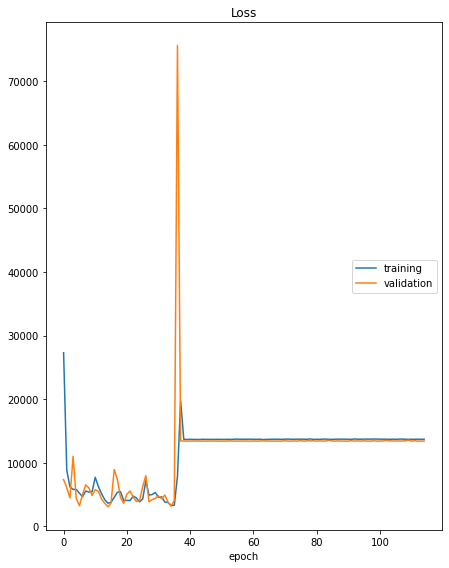

Loss
	training         	 (min: 3292.281, max: 27297.314, cur: 13710.211)
	validation       	 (min: 3080.547, max: 75618.656, cur: 13412.049)


In [8]:
# create model
model_dl_all = Sequential()
model_dl_all.add(Dense(90, input_dim=46, activation='relu'))
model_dl_all.add(Dense(50,  activation='relu'))
model_dl_all.add(Dense(1,  activation='linear'))

# custom loss function
mean = np.mean(label_all)
std = np.std(label_all)
from keras import backend as k
def root_mean_squared_error(y_true, y_pred):
    y_true = (y_true*std)+mean # descaling variable
    y_pred = (y_pred*std)+mean # descaling variable
    return k.sqrt(k.mean(k.square(y_pred - y_true))) 

# callbacks
loss = ModelCheckpoint('Models/best_model_dl_all.h5', monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(patience=100)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model_dl_all.compile(loss= root_mean_squared_error, optimizer=opt)

model_dl_all.fit(x_train_all, y_train_all, validation_data=(x_test_all, y_test_all), epochs=1000, batch_size=128, callbacks=[loss, es, PlotLossesKeras()])

In [9]:
# accuracy of the model
svd_model_all = keras.models.load_model('Models/best_model_dl_all.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

y_pred_all = lab_scaler_all.inverse_transform(svd_model_all.predict(x_test_all).reshape(-1, 1))
y_test_all_ = lab_scaler_all.inverse_transform(y_test_all)
print('RMSE: ', mean_squared_error(y_test_all_, y_pred_all ,squared=False))

RMSE:  3240.7950058292517


## Model with Selected Columns

#### Model 1

In [10]:
col1 = ['open', 'high', 'low', 'market_cap', 'market_cap_global']

# features and label (all features used)
features_sel = train[col1]
label_sel = train[['close']]
print(features_sel.shape, label_sel.shape)

features_sel.head()

(12632, 5) (12632, 1)


,open,high,low,market_cap,market_cap_global
0,9422.849081,9428.490628,9422.849081,1.737635e+11,2.818066e+11
1,7985.359278,7992.059917,7967.567267,1.426942e+11,2.126897e+11
2,49202.033778,49394.593518,49068.057046,9.166977e+11,1.530712e+12
3,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
4,10535.737119,10535.737119,10384.798216,1.921183e+11,3.386925e+11


In [11]:
# standardize
feat_scaler_sel = StandardScaler().fit(features_sel)
lab_scaler_sel = StandardScaler().fit(label_sel)
features_selS = feat_scaler_sel.transform(features_sel)
label_selS = lab_scaler_sel.transform(label_sel)

# train test split
x_train_sel, x_test_sel, y_train_sel, y_test_sel = train_test_split(features_selS, label_selS, test_size=0.2, random_state=42)
print(x_train_sel.shape, x_test_sel.shape, y_train_sel.shape, y_test_sel.shape)

(10105, 5) (2527, 5) (10105, 1) (2527, 1)


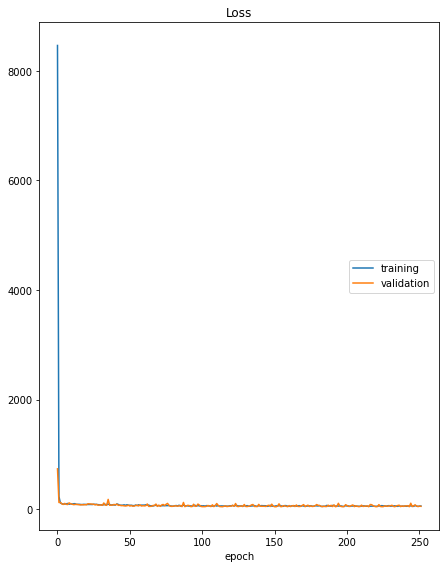

Loss
	training         	 (min:   48.258, max: 8465.368, cur:   56.083)
	validation       	 (min:   43.043, max:  735.354, cur:   51.031)


In [12]:
# create model
model_dl_sel = Sequential()
model_dl_sel.add(Dense(25, input_dim=5, activation='relu'))
model_dl_sel.add(Dense(50,  activation='relu'))
model_dl_sel.add(Dense(1,  activation='linear'))

# custom loss function
mean = np.mean(label_sel)
std = np.std(label_sel)
from keras import backend as k
def root_mean_squared_error(y_true, y_pred):
    y_true = (y_true*std)+mean # descaling variable
    y_pred = (y_pred*std)+mean # descaling variable
    return k.sqrt(k.mean(k.square(y_pred - y_true))) 

# callbacks
loss = ModelCheckpoint('Models/best_model_dl_sel.h5', monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(patience=100)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_dl_sel.compile(loss= root_mean_squared_error, optimizer=opt)

model_dl_sel.fit(x_train_sel, y_train_sel, validation_data=(x_test_sel, y_test_sel), epochs=1000, batch_size=128, callbacks=[loss, es, PlotLossesKeras()])

In [13]:
# accuracy of the model
svd_model_sel = keras.models.load_model('Models/best_model_dl_sel.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

y_pred_sel = lab_scaler_sel.inverse_transform(svd_model_sel.predict(x_test_sel).reshape(-1, 1))
y_test_sel_ = lab_scaler_sel.inverse_transform(y_test_sel)
print('RMSE: ', mean_squared_error(y_test_sel_, y_pred_sel ,squared=False))

RMSE:  46.31815227371583


#### Model 2

In [14]:
col2 = ['high', 'low', 'market_cap', 'volume', 'reddit_comments', 'volatility']

# features and label (all features used)
features_sel2 = train[col2]
label_sel2 = train[['close']]
print(features_sel2.shape, label_sel2.shape)

features_sel2.head()

(12632, 6) (12632, 1)


,high,low,market_cap,volume,reddit_comments,volatility
0,9428.490628,9422.849081,1.737635e+11,7.131986e+08,61.0,0.007118
1,7992.059917,7967.567267,1.426942e+11,4.004755e+08,103.0,0.009419
2,49394.593518,49068.057046,9.166977e+11,3.017729e+09,187.0,0.013530
3,0.000000,0.000000,0.000000e+00,0.000000e+00,268.0,0.000000
4,10535.737119,10384.798216,1.921183e+11,1.150053e+09,50.0,0.010332


In [15]:
# standardize
feat_scaler_sel2 = StandardScaler().fit(features_sel2)
lab_scaler_sel2 = StandardScaler().fit(label_sel2)
features_sel2S = feat_scaler_sel2.transform(features_sel2)
label_sel2S = lab_scaler_sel2.transform(label_sel2)

# train test split
x_train_sel2, x_test_sel2, y_train_sel2, y_test_sel2 = train_test_split(features_sel2S, label_sel2S, test_size=0.2, random_state=42)
print(x_train_sel2.shape, x_test_sel2.shape, y_train_sel2.shape, y_test_sel2.shape)

(10105, 6) (2527, 6) (10105, 1) (2527, 1)


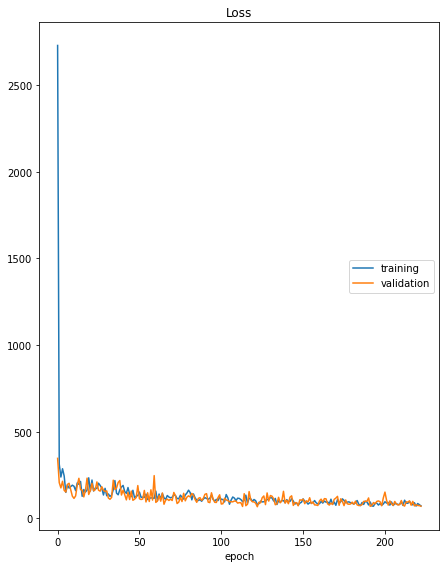

Loss
	training         	 (min:   70.218, max: 2729.075, cur:   71.929)
	validation       	 (min:   67.086, max:  346.302, cur:   70.204)


In [16]:
# create model
model_dl_sel2 = Sequential()
model_dl_sel2.add(Dense(36, input_dim=6, activation='relu'))
model_dl_sel2.add(Dense(50,  activation='relu'))
model_dl_sel2.add(Dense(1,  activation='linear'))

# custom loss function
mean = np.mean(label_sel2)
std = np.std(label_sel2)
from keras import backend as k
def root_mean_squared_error(y_true, y_pred):
    y_true = (y_true*std)+mean # descaling variable
    y_pred = (y_pred*std)+mean # descaling variable
    return k.sqrt(k.mean(k.square(y_pred - y_true))) 

# callbacks
loss = ModelCheckpoint('Models/best_model_dl_sel2.h5', monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(patience=100)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_dl_sel2.compile(loss= root_mean_squared_error, optimizer=opt)

model_dl_sel2.fit(x_train_sel2, y_train_sel2, validation_data=(x_test_sel2, y_test_sel2), epochs=1000, batch_size=128, callbacks=[loss, es, PlotLossesKeras()])

In [17]:
# accuracy of the model
svd_model_sel2 = keras.models.load_model('Models/best_model_dl_sel2.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

y_pred_sel2 = lab_scaler_sel2.inverse_transform(svd_model_sel2.predict(x_test_sel2).reshape(-1, 1))
y_test_sel2_ = lab_scaler_sel2.inverse_transform(y_test_sel2)
print('RMSE: ', mean_squared_error(y_test_sel2_, y_pred_sel2 ,squared=False))

RMSE:  74.14505866928003


## Model with Features reduction

#### Function for feature redcution

In [18]:
def apply_pca_grp(dataframe):
    """HELPER FUNCTION:This function will apply pca to some similar groups of columns
       and will convert them into 1 col per group."""
    df = dataframe.fillna(0).copy()  
    df = df.drop(['asset_id'], axis=1)
    # column over pca to be applied
    twitter = ['tweets', 'tweet_spam', 'tweet_followers', 'tweet_quotes', 'tweet_retweets', 'tweet_replies', 'tweet_favorites']
    tweet_sent = ['tweet_sentiment1', 'tweet_sentiment2', 'tweet_sentiment3', 'tweet_sentiment4', 'tweet_sentiment5']
    tweet_impt = ['tweet_sentiment_impact1', 'tweet_sentiment_impact2', 'tweet_sentiment_impact3', 
                  'tweet_sentiment_impact4', 'tweet_sentiment_impact5']
    reddit = ['reddit_posts', 'reddit_posts_score', 'reddit_comments', 'reddit_comments_score']
    other = ['volume', 'url_shares', 'unique_url_shares', 'social_score', 'average_sentiment',
             'news', 'price_score', 'social_impact_score', 'correlation_rank', 'galaxy_score',
             'volatility', 'market_cap_rank', 'percent_change_24h_rank', 'volume_24h_rank',
             'social_volume_24h_rank', 'social_score_24h_rank', 'medium', 'youtube', 
             'social_volume', 'percent_change_24h']
    
    pca_candidate = ['twitter', 'tweet_sent', 'tweet_impt', 'reddit', 'other']
    
    # apply pca
    for col in pca_candidate:
        df[col] = PCA(n_components=1).fit_transform(df[eval(col)])
    
    # removing columns which are reduced
    drp_col = twitter+tweet_sent+tweet_impt+reddit+other
    df = df.drop(drp_col, axis=1)
    
    return df   
def apply_pca_all(dataframe, reduce_to, train):
    """HELPER FUNCTION:This function will apply pca to all columns"""
    # preparing dataset
    df = dataframe.fillna(0).copy()
    df = df.drop(['asset_id'], axis=1)
    
    # apply pca
    if train==True:
        pca_candidate = list(df.drop(['id', 'close'], axis=1).columns)
    else:
        pca_candidate = list(df.drop(['id'], axis=1).columns)
        
    reduced_col = PCA(n_components=reduce_to).fit_transform(df[pca_candidate])
    
    # adjusting columns
    for i in range(reduce_to):
        df['reduced'+str(i)] = reduced_col[:, i]
        
    df = df.drop(pca_candidate, axis=1)
    return df  
def apply_pca_selected(dataframe, touch_not_col, reduce_to, train):
    """HELPER FUNCTION:This function will apply pca on all columns expect touch_not_col"""
    # preparing dataset
    df = dataframe.fillna(0).copy()
    df = df.drop(['asset_id'], axis=1)
    
    # apply pca
    if train==True:
        pca_candidate = list(df.drop(touch_not_col+['id', 'close'], axis=1).columns)
    else:
        pca_candidate = list(df.drop(touch_not_col+['id'], axis=1).columns)
        
    reduced_col = PCA(n_components=reduce_to).fit_transform(df[pca_candidate])
    
    # adjusting columns
    for i in range(reduce_to):
        df['reduced'+str(i)] = reduced_col[:, i]
        
    df = df.drop(pca_candidate, axis=1)
    return df
def apply_pca(dataframe, train=True, option='grp', reduce_to=10, touch_not_col=['open', 'high', 'low', 'market_cap', 'market_cap_global']):
    """This function will apply pca to 'all' or 'selected' or 'group' columns based on the option parameter
       
       Attributes:
       dataframe: Pandas dataframe
       option: pca to apply on, option available ['grp', 'all', 'selected']
       reduce_to: In how many column it should be reduced, only applicable to option 'all', 'selected'
       touch_not_col: On which column pca should not be applied, only applicable to option "selected"
       """
    if option=='grp':
        return apply_pca_grp(dataframe)
    elif option=='all':
        return apply_pca_all(dataframe, reduce_to, train)
    else: return apply_pca_selected(dataframe, touch_not_col, reduce_to, train)

#### Model 1
We are reducing 5 similiar group of columns into 5 different columns representing each group i.e,
```
top_col1 = ['open', 'high', 'low', 'market_cap', 'market_cap_global', 'reddit_posts', 'percent_change_24h', 'tweet_spam', 'reddit_comments','medium', 'tweets', 'tweet_sentiment2', 'volatility', 'volume', 'volume_24h_rank']
top_col2 = ['tweet_spam', 'market_cap_global', 'high', 'open', 'market_cap', 'low', 'tweet_sentiment2']
top_col3 = ['open', 'high', 'low', 'market_cap', 'tweet_favorites', 'market_cap_global', 'percent_change_24h', 'tweet_sentiment_impact5', 'tweet_replies', 'reddit_posts']
top_col4 = ['open', 'high', 'low', 'market_cap', 'market_cap_global']
```
Also we are using columns `['open', 'high', 'low', 'market_cap', 'market_cap_global']`

In [19]:
# applying pca
df = apply_pca(dataframe=df_train, train=True, option='grp', touch_not_col=col1)

# features and label (all features used)
features_pca_grp = df.drop(['id', 'close'], axis=1)
label_pca_grp = df[['close']]
print(features_pca_grp.shape, label_pca_grp.shape)

features_pca_grp.head()

(12632, 10) (12632, 1)


,open,high,low,market_cap,market_cap_global,twitter,tweet_sent,tweet_impt,reddit,other
0,9422.849081,9428.490628,9422.849081,1.737635e+11,2.818066e+11,-3.534499e+06,235.584575,-1.473503e+06,-99.971008,-1.728848e+08
1,7985.359278,7992.059917,7967.567267,1.426942e+11,2.126897e+11,-9.292552e+06,-1198.880632,-6.098447e+06,171.268668,-4.856402e+08
2,49202.033778,49394.593518,49068.057046,9.166977e+11,1.530712e+12,3.256838e+07,4590.421375,1.742065e+07,556.896359,2.131840e+09
3,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.521037e+07,-2325.726916,-1.000922e+07,79.677827,-8.861472e+08
4,10535.737119,10535.737119,10384.798216,1.921183e+11,3.386925e+11,-7.881944e+05,15.670753,1.034000e+06,-199.364739,2.639785e+08


In [20]:
# standardize
feat_scaler_pca_grp = StandardScaler().fit(features_pca_grp)
lab_scaler_pca_grp = StandardScaler().fit(label_pca_grp)
features_pca_grpS = feat_scaler_pca_grp.transform(features_pca_grp)
label_pca_grpS = lab_scaler_pca_grp.transform(label_pca_grp)

# train test split
x_train_pca_grp, x_test_pca_grp, y_train_pca_grp, y_test_pca_grp = train_test_split(features_pca_grpS, label_pca_grpS, test_size=0.2, random_state=42)
print(x_train_pca_grp.shape, x_test_pca_grp.shape, y_train_pca_grp.shape, y_test_pca_grp.shape)

(10105, 10) (2527, 10) (10105, 1) (2527, 1)


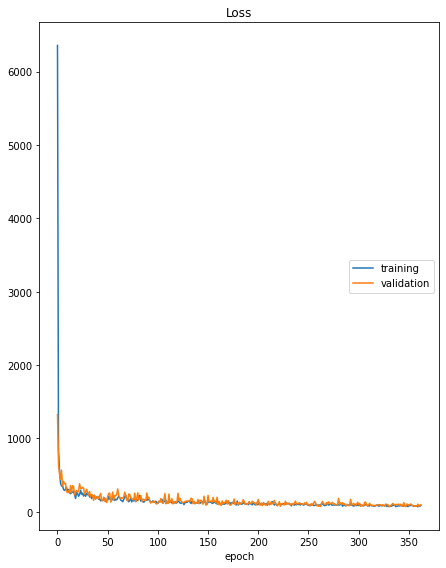

Loss
	training         	 (min:   69.607, max: 6357.318, cur:   86.409)
	validation       	 (min:   72.363, max: 1324.634, cur:   94.650)


In [21]:
# create model
model_dl_pca_grp = Sequential()
model_dl_pca_grp.add(Dense(25, input_dim=10, activation='relu'))
model_dl_pca_grp.add(Dense(50,  activation='relu'))
model_dl_pca_grp.add(Dense(1,  activation='linear'))

# custom loss function
mean = np.mean(label_pca_grp)
std = np.std(label_pca_grp)
from keras import backend as k
def root_mean_squared_error(y_true, y_pred):
    y_true = (y_true*std)+mean # descaling variable
    y_pred = (y_pred*std)+mean # descaling variable
    return k.sqrt(k.mean(k.square(y_pred - y_true))) 

# callbacks
loss = ModelCheckpoint('Models/best_model_dl_pca_grp.h5', monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(patience=100)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_dl_pca_grp.compile(loss= root_mean_squared_error, optimizer=opt)

model_dl_pca_grp.fit(x_train_pca_grp, y_train_pca_grp, validation_data=(x_test_pca_grp, y_test_pca_grp), epochs=1000, batch_size=128, callbacks=[loss, es, PlotLossesKeras()])

In [22]:
# accuracy of the model
svd_model_pca_grp = keras.models.load_model('Models/best_model_dl_pca_grp.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

y_pred_pca_grp = lab_scaler_pca_grp.inverse_transform(svd_model_pca_grp.predict(x_test_pca_grp).reshape(-1, 1))
y_test_pca_grp_ = lab_scaler_pca_grp.inverse_transform(y_test_pca_grp)
print('RMSE: ', mean_squared_error(y_test_pca_grp_, y_pred_pca_grp ,squared=False))

RMSE:  76.87298025426303


#### Model 2
We are reducing all columns from the dataset to 10 columns

In [23]:
# applying pca
df = apply_pca(dataframe=df_train, train=True, option='all', reduce_to=10, touch_not_col=col1)

# features and label (all features used)
features_pca_all = df.drop(['id', 'close'], axis=1)
label_pca_all = df[['close']]
print(features_pca_all.shape, label_pca_all.shape)

features_pca_all.head()

(12632, 10) (12632, 1)


,reduced0,reduced1,reduced2,reduced3,reduced4,reduced5,reduced6,reduced7,reduced8,reduced9
0,-2.712023e+10,6.007328e+07,-1.362622e+08,-3.457140e+06,8.034258e+05,-6.606139e+05,-4.765413e+05,-4.520503e+04,-3.452360e+05,-71128.060278
1,-1.024500e+11,8.298299e+09,-4.482707e+08,-1.349089e+07,-9.507625e+05,-7.266522e+05,2.338168e+05,7.469529e+05,-7.661126e+04,-64145.095442
2,1.426036e+12,7.637546e+09,7.080443e+07,-3.080495e+07,-5.423213e+05,-7.425719e+05,2.994991e+06,-5.469449e+06,-3.240054e+06,259508.413931
3,-3.581191e+11,-6.932511e+09,-3.058471e+08,5.310447e+05,-3.120763e+05,1.113340e+06,9.289401e+04,-4.121936e+05,2.429062e+05,51365.998100
4,3.122242e+10,-1.293871e+10,3.828446e+08,5.294927e+06,2.941860e+06,1.296638e+05,-1.162133e+06,-3.056486e+05,-1.717026e+05,-78478.236421


In [24]:
# standardize
feat_scaler_pca_all = StandardScaler().fit(features_pca_all)
lab_scaler_pca_all = StandardScaler().fit(label_pca_all)
features_pca_allS = feat_scaler_pca_all.transform(features_pca_all)
label_pca_allS = lab_scaler_pca_all.transform(label_pca_all)

# train test split
x_train_pca_all, x_test_pca_all, y_train_pca_all, y_test_pca_all = train_test_split(features_pca_allS, label_pca_allS, test_size=0.2, random_state=42)
print(x_train_pca_all.shape, x_test_pca_all.shape, y_train_pca_all.shape, y_test_pca_all.shape)

(10105, 10) (2527, 10) (10105, 1) (2527, 1)


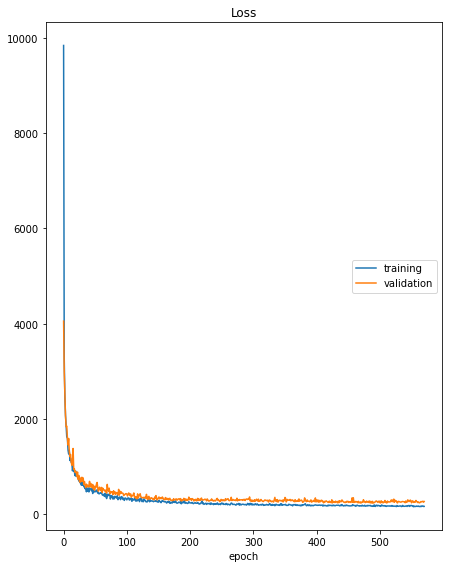

Loss
	training         	 (min:  162.423, max: 9837.383, cur:  169.606)
	validation       	 (min:  237.281, max: 4054.829, cur:  272.779)


In [25]:
# create model
model_dl_pca_all = Sequential()
model_dl_pca_all.add(Dense(25, input_dim=10, activation='relu'))
model_dl_pca_all.add(Dense(50,  activation='relu'))
model_dl_pca_all.add(Dense(1,  activation='linear'))

# custom loss function
mean = np.mean(label_pca_all)
std = np.std(label_pca_all)
from keras import backend as k
def root_mean_squared_error(y_true, y_pred):
    y_true = (y_true*std)+mean # descaling variable
    y_pred = (y_pred*std)+mean # descaling variable
    return k.sqrt(k.mean(k.square(y_pred - y_true))) 

# callbacks
loss = ModelCheckpoint('Models/best_model_dl_pca_all.h5', monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(patience=100)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_dl_pca_all.compile(loss= root_mean_squared_error, optimizer=opt)

model_dl_pca_all.fit(x_train_pca_all, y_train_pca_all, validation_data=(x_test_pca_all, y_test_pca_all), epochs=1000, batch_size=128, callbacks=[loss, es, PlotLossesKeras()])

In [26]:
# accuracy of the model
svd_model_pca_all = keras.models.load_model('Models/best_model_dl_pca_all.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

y_pred_pca_all = lab_scaler_pca_all.inverse_transform(svd_model_pca_all.predict(x_test_pca_all).reshape(-1, 1))
y_test_pca_all_ = lab_scaler_pca_all.inverse_transform(y_test_pca_all)
print('RMSE: ', mean_squared_error(y_test_pca_all_, y_pred_pca_all ,squared=False))

RMSE:  264.40818112586317


#### Model 3
we are redcuing all columns into 1 columns expect the selected columns which are `['open', 'high', 'low', 'market_cap', 'market_cap_global']`

In [27]:
# applying pca
df = apply_pca(dataframe=df_train, train=True, option='selected', reduce_to=1, touch_not_col=col1)

# features and label (all features used)
features_pca_sel = df.drop(['id', 'close'], axis=1)
label_pca_sel = df[['close']]
print(features_pca_sel.shape, label_pca_sel.shape)

features_pca_sel.head()

(12632, 6) (12632, 1)


,open,high,low,market_cap,market_cap_global,reduced0
0,9422.849081,9428.490628,9422.849081,1.737635e+11,2.818066e+11,-1.729102e+08
1,7985.359278,7992.059917,7967.567267,1.426942e+11,2.126897e+11,-4.857147e+08
2,49202.033778,49394.593518,49068.057046,9.166977e+11,1.530712e+12,2.132071e+09
3,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-8.862661e+08
4,10535.737119,10535.737119,10384.798216,1.921183e+11,3.386925e+11,2.639682e+08


In [28]:
# standardize
feat_scaler_pca_sel = StandardScaler().fit(features_pca_sel)
lab_scaler_pca_sel = StandardScaler().fit(label_pca_sel)
features_pca_selS = feat_scaler_pca_sel.transform(features_pca_sel)
label_pca_selS = lab_scaler_pca_sel.transform(label_pca_sel)

# train test split
x_train_pca_sel, x_test_pca_sel, y_train_pca_sel, y_test_pca_sel = train_test_split(features_pca_selS, label_pca_selS, test_size=0.2, random_state=42)
print(x_train_pca_sel.shape, x_test_pca_sel.shape, y_train_pca_sel.shape, y_test_pca_sel.shape)

(10105, 6) (2527, 6) (10105, 1) (2527, 1)


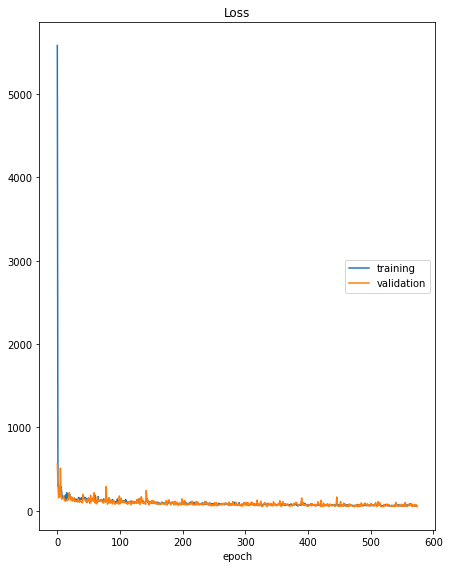

Loss
	training         	 (min:   52.777, max: 5583.780, cur:   52.777)
	validation       	 (min:   48.600, max:  560.855, cur:   52.140)


In [29]:
# create model
model_dl_pca_sel = Sequential()
model_dl_pca_sel.add(Dense(25, input_dim=6, activation='relu'))
model_dl_pca_sel.add(Dense(50,  activation='relu'))
model_dl_pca_sel.add(Dense(1,  activation='linear'))

# custom loss function
mean = np.mean(label_pca_sel)
std = np.std(label_pca_sel)
from keras import backend as k
def root_mean_squared_error(y_true, y_pred):
    y_true = (y_true*std)+mean # descaling variable
    y_pred = (y_pred*std)+mean # descaling variable
    return k.sqrt(k.mean(k.square(y_pred - y_true))) 

# callbacks
loss = ModelCheckpoint('Models/best_model_dl_pca_sel.h5', monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(patience=100)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_dl_pca_sel.compile(loss= root_mean_squared_error, optimizer=opt)

model_dl_pca_sel.fit(x_train_pca_sel, y_train_pca_sel, validation_data=(x_test_pca_sel, y_test_pca_sel), epochs=1000, batch_size=128, callbacks=[loss, es, PlotLossesKeras()])

In [30]:
# accuracy of the model
svd_model_pca_sel = keras.models.load_model('Models/best_model_dl_pca_sel.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

y_pred_pca_sel = lab_scaler_pca_sel.inverse_transform(svd_model_pca_sel.predict(x_test_pca_sel).reshape(-1, 1))
y_test_pca_sel_ = lab_scaler_pca_sel.inverse_transform(y_test_pca_sel)
print('RMSE: ', mean_squared_error(y_test_pca_sel_, y_pred_pca_sel ,squared=False))

RMSE:  53.090967798182696


## Pseudo Labelling

Here we will use the best model to predict our test data and then we will merge that test data with train to increase our train data size. And with that data we will create new model to predict the test data.

In our current situation the best model seems to be **`Model 1`** in **`Model with selected columns`**, so we will use that

In [31]:
# predicting test data
test = df_test.fillna(0).copy()
test_feat = feat_scaler_sel.transform(test[col1])
test_lab = svd_model_sel.predict(test_feat)

# merging data
train_test_feat = np.concatenate((features_selS, test_feat), axis=0)
train_test_lab = np.concatenate((label_selS, test_lab), axis=0)
print(train_test_feat.shape, train_test_lab.shape)

pd.DataFrame(train_test_feat, columns=col1).head()

(18854, 5) (18854, 1)


,open,high,low,market_cap,market_cap_global
0,-0.084191,-0.086039,-0.081871,-0.053750,-0.054072
1,-0.189076,-0.190289,-0.188614,-0.175735,-0.213710
2,2.818265,2.814527,2.826053,2.863164,2.830502
3,-0.771721,-0.770318,-0.773025,-0.735982,-0.704956
4,-0.002990,-0.005680,-0.011313,0.018314,0.077316


In [32]:
# train test split (data is already scaled so we are skipping that)
x_train_tt, x_test_tt, y_train_tt, y_test_tt = train_test_split(train_test_feat, train_test_lab, test_size=0.2, random_state=42)
print(x_train_tt.shape, x_test_tt.shape, y_train_tt.shape, y_test_tt.shape)

(15083, 5) (3771, 5) (15083, 1) (3771, 1)


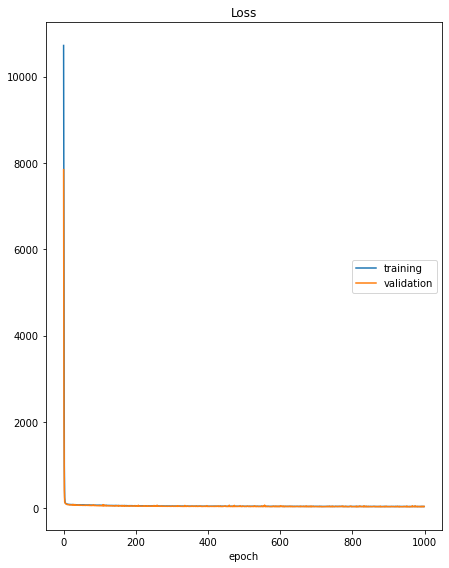

Loss
	training         	 (min:   38.483, max: 10720.020, cur:   39.090)
	validation       	 (min:   34.448, max: 7843.195, cur:   39.845)


In [33]:
# create model
model_dl_tt = Sequential()
model_dl_tt.add(Dense(25, input_dim=5, activation='relu'))
model_dl_tt.add(Dense(50,  activation='relu'))
model_dl_tt.add(Dense(1,  activation='linear'))

# custom loss function
mean = np.mean(label_sel)
std = np.std(label_sel)
from keras import backend as k
def root_mean_squared_error(y_true, y_pred):
    y_true = (y_true*std)+mean # descaling variable
    y_pred = (y_pred*std)+mean # descaling variable
    return k.sqrt(k.mean(k.square(y_pred - y_true))) 

# callbacks
loss = ModelCheckpoint('Models/best_model_dl_tt.h5', monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(patience=100)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_dl_tt.compile(loss= root_mean_squared_error, optimizer=opt)

model_dl_tt.fit(x_train_tt, y_train_tt, validation_data=(x_test_tt, y_test_tt), epochs=1000, batch_size=128, callbacks=[loss, es, PlotLossesKeras()])

In [34]:
# accuracy of the model
svd_model_tt = keras.models.load_model('Models/best_model_dl_tt.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})

y_pred_tt = lab_scaler_sel.inverse_transform(svd_model_tt.predict(x_test_tt).reshape(-1, 1))
y_test_tt_ = lab_scaler_sel.inverse_transform(y_test_tt)
print('RMSE: ', mean_squared_error(y_test_tt_, y_pred_tt ,squared=False))

RMSE:  36.46735691667548


In [40]:
test_features

array([[        nan,         nan,         nan,         nan,         nan],
       [ 0.05533254,  0.05353824,  0.05838733,  0.08909618,  0.13370191],
       [-0.31040049, -0.31103319, -0.31131552, -0.28295158, -0.29589373],
       ...,
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       [-0.25672717, -0.2565571 , -0.25574525, -0.23519118, -0.25998235]])

## Submission

In [51]:
test_features = df_test[col1].fillna(0)
test_features = feat_scaler_sel.transform(test_features)

# prediction
close = svd_model_tt.predict(test_features)
close_descale = lab_scaler_sel.inverse_transform(close)

# sub dataframe
sub = pd.DataFrame({'id': df_test['id']})
sub['close'] = close_descale
sub.head()

,id,close
0,ID_323Sn2,0.238329
1,ID_325SNW,11357.467773
2,ID_325uzE,6312.484863
3,ID_328qCx,0.238329
4,ID_3293uJ,0.238329


In [50]:
sub.to_csv('dl_sub2.csv', index=False)

In [46]:
df_test.shape

(6222, 48)